# Found feature NN hyperparameter search

A feed forward NN that only gets the input features that XGBoost finds to be important.

# Which hyperparameters I chose:

Looking at the results table (FeatureNN_HPS_results.csv), sorted by best_saved_val_acc (see this table at the end of this notebook), I have decided to use the hyperparameters from run 43:

input_dropout: True 
l_reg : None 
lr: 0.001
num_hiddens : [D_in, 256, 256, 128] 
order_reg_layers: BN_dropout 

which gave the results:
best_saved_val_acc: 0.98501
val_loss: 0.118187
val_categorical_accuracy: 0.984297
loss: 0.084021
categorical_accuracy: 0.971227

Why I chose this set of hyperparameters:
- scored the highest saved_best_val_acc
- one of the lowest val losses and the highest val acc at 500 epochs
- has dropout and batch normalisation, which are regularisation and will hopefully encourage generalisation
- default adam learning rate
- doesn't score perfectly on the training set, so it doesn't overfit as much as some other networks

In [11]:
cancer_type = '' # currently only works for cancer_type = ''
use_small = False
seed = 42
label = 'FeatureNN'

In [12]:
# get the data
import numpy as np
import pandas as pd
try:
    Xtrain_subset = pd.read_csv('TCGA-all-just-xgboost-features_train.csv', sep = '\t', index_col = 0)
    Xtrain_subset = Xtrain_subset.transpose()
    Xtrain_subset = np.array(Xtrain_subset)
    
    Xtest_subset = pd.read_csv('TCGA-all-just-xgboost-features_test.csv', sep = '\t', index_col = 0)
    Xtest_subset = Xtest_subset.transpose()
    Xtest_subset = np.array(Xtest_subset)

    ytrain = pd.read_csv('TCGA-all-diagnoses_train.csv', sep = '\t', index_col=0)
    ytest = pd.read_csv('TCGA-all-diagnoses_test.csv', sep = '\t', index_col=0)
    ytrain = np.array(ytrain)
    ytest = np.array(ytest)
    
except: # loading the data and extracting important features:
    # get the important features, found by xgboost
    features = pd.read_csv('../../xgboost/feature_importances/' +cancer_type+ '_run_0.csv', header = None)
    feature_nums = [int(features[0][i].split(' ')[2]) for i in range(len(features[0]))]
    len(feature_nums)
    
    # load whole input data and pick out probes in feature_nums

    import sys
    import os

    cwd = os.getcwd() # get the current path, and only take up to methylation-patterns-izzy (discarding the end bit)
    file = 'methylation-patterns-izzy'
    end = cwd.find(file) + len(file) + 1 # find start of file in path, add on its lenth to go to the end, and add on 1 to get the /
    path = cwd[0:end]
    print("path is ", path)
    sys.path.append(path)

    from get_train_and_test import get_train_and_test
    Xtrain, Xtest, ytrain, ytest = get_train_and_test(cancer_type, use_small, remove_inf = True, use_beta = False, root_path=path, model_type = cancer_type + label, seed = seed)
    
    Xtrain_subset = Xtrain[:, feature_nums]
    Xtest_subset = Xtest[:, feature_nums]
    
    # testing:
    Xtrain_subset.shape
    Xtest_subset.shape

    Xtrain[:, 6] # should be equal
    Xtrain_subset[:, 5]

    Xtest[:, 6]
    Xtest_subset[:, 5]
    
    # keras needs targets in one hot format:
    from keras.utils import to_categorical
    ytrain = to_categorical(ytrain)
    ytest = to_categorical(ytest)

In [13]:
# checks:
Xtrain_subset.shape
Xtest_subset.shape
ytrain.shape
ytest.shape

(4668, 1781)

(1556, 1781)

(4668, 14)

(1556, 14)

In [14]:
# print(ytrain)
import numpy as np
num_classes = len(np.unique(ytest, axis=0))
print("num classes is ", num_classes)

num classes is  14


In [15]:
##### model parameters
D_in=Xtrain_subset.shape[1] # input dimension (number of features)
num_epochs = 500
# num_hiddens = [D_in, 256, 256, 128] # in 500 epochs got best val acc of 0.96467, train loss still higher than val loss

# order_reg_layers = 'BN_dropout' # can be 'BN_dropout', 'dropout_BN', 'dropout', or 'BN'. The order of the regularisation layers

# input_dropout = True # whether to have dropout before first layer

# num_hiddens = [D_in, 128, 64] # in 500 epochs got best val acc of 0.97645, train loss still higher than val loss
batch_size = 20
# lr = 0.0001

# l_reg = keras.regularizers.l1(0.005) # regularizers.l1(0.01) # can be regularizers.l1(x) or regularizers.l2(x), or None
# applied to the weights of the network
# l1 regularisation on the weights results in sparse weights (this might be called weight decay?) (but might be less efficient than l2), l2 results in lower weights (but not sparse)
import keras

to_try = {
    'l_reg': [keras.regularizers.l1(0.005), None],
    'order_reg_layers': ['BN_dropout', 'dropout_BN', 'dropout', 'BN'],
    'input_dropout': [True, False],
    'num_hiddens': [[D_in, 128, 64], [D_in, 256, 256, 128], [D_in, 128, 128, 64, 64], [D_in, 512, 256]], # shallow and narrow, reasonable, deep and narrow, shallow and wide
    'lr': [0.0001, 0.0005, 0.001] # default, 2*default, 10*default
}

In [20]:

def featureNN(Xtrain, ytrain, x_val, y_val, params):

    # get rid of old stored models
    import tensorflow as tf
    tf.keras.backend.clear_session()

    from keras.models import Sequential
    model = Sequential()

    from keras.layers import Dense, Dropout, BatchNormalization

    if params['input_dropout'] == True:
        model.add(Dropout(rate = 0.2)) # the dropout paper suggests a 0.8 keep rate (0.2 dropout) for the input
    for layer in range(1, len(params['num_hiddens'])):
        model.add(Dense(units=params['num_hiddens'][layer], activation='relu', input_dim=params['num_hiddens'][layer-1], kernel_regularizer = params['l_reg']))

        if params['order_reg_layers'] == 'BN_dropout':
            model.add(BatchNormalization())
            model.add(Dropout(rate = 0.5)) # the dropout paper suggests a rate of 0.5
        elif params['order_reg_layers'] == 'dropout_BN':
            model.add(Dropout(rate = 0.5)) # the dropout paper suggests a rate of 0.5
            model.add(BatchNormalization())
        elif params['order_reg_layers'] == 'dropout':
            model.add(Dropout(rate = 0.5)) # the dropout paper suggests a rate of 0.5
        elif params['order_reg_layers'] == 'BN':
            model.add(BatchNormalization())
        else:
            print("don't know that order_reg_layers, ", order_reg_layers)

    model.add(Dense(units=num_classes, activation='softmax')) # last layer

    # think BN goes before activtion, BUT some say its better after activtion - try both. Try BN after dropout? And some say its not good to also have dropout
    # see https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

    model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=params['lr']),
              metrics=['categorical_accuracy'])
    
    # this saves the best model so far:
    save_best_models = keras.callbacks.callbacks.ModelCheckpoint('FeatureNN_'+cancer_type + '_best_model', monitor='val_categorical_accuracy', verbose=1, save_best_only=True)
    history = model.fit(Xtrain, ytrain, epochs=num_epochs, batch_size=batch_size, validation_data = [x_val,y_val], callbacks = [save_best_models])
    
    # load best model found
    from keras.models import load_model
    model = load_model('FeatureNN_'+cancer_type + '_best_model')

    losses = history.history["loss"]
    val_loss = history.history["val_loss"]

    import matplotlib.pyplot as plt
    plt.clf()
    plt.plot(losses)
    plt.plot(val_loss)
    plt.legend(["train loss", "val loss"])
    
    return history, model



  0%|          | 0/48 [00:00<?, ?it/s]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 557us/step - loss: 36.6102 - categorical_accuracy: 0.1047 - val_loss: 33.9205 - val_categorical_accuracy: 0.4133

Epoch 00001: val_categorical_accuracy improved from -inf to 0.41328, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 430us/step - loss: 32.9160 - categorical_accuracy: 0.1879 - val_loss: 30.7563 - val_categorical_accuracy: 0.6331

Epoch 00002: val_categorical_accuracy improved from 0.41328 to 0.63312, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 410us/step - loss: 30.1454 - categorical_accuracy: 0.2614 - val_loss: 28.3464 - val_categorical_accuracy: 0.6645

Epoch 00003: val_categorical_accuracy improved from 0.63312 to 0.66453, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 401us/step - loss: 27.8210 - categorical_ac



  2%|▏         | 1/48 [11:02<8:38:57, 662.50s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 504us/step - loss: 26.8766 - categorical_accuracy: 0.5430 - val_loss: 17.8557 - val_categorical_accuracy: 0.9372

Epoch 00001: val_categorical_accuracy improved from -inf to 0.93719, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 386us/step - loss: 13.1236 - categorical_accuracy: 0.8072 - val_loss: 9.6768 - val_categorical_accuracy: 0.6488

Epoch 00002: val_categorical_accuracy did not improve from 0.93719
Epoch 3/500
3267/3267 [==============================] - 1s 368us/step - loss: 7.2480 - categorical_accuracy: 0.8338 - val_loss: 6.2237 - val_categorical_accuracy: 0.6667

Epoch 00003: val_categorical_accuracy did not improve from 0.93719
Epoch 4/500
3267/3267 [==============================] - 1s 393us/step - loss: 5.3268 - categorical_accuracy: 0.8157 - val_loss: 7.9861 - val_categorical_accuracy: 0.3455

Epoch 00004: val_cat



  4%|▍         | 2/48 [21:03<8:13:47, 644.07s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 418us/step - loss: 3.3688 - categorical_accuracy: 0.0949 - val_loss: 2.6092 - val_categorical_accuracy: 0.2427

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24268, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 363us/step - loss: 2.6292 - categorical_accuracy: 0.1377 - val_loss: 2.5751 - val_categorical_accuracy: 0.2256

Epoch 00002: val_categorical_accuracy did not improve from 0.24268
Epoch 3/500
3267/3267 [==============================] - 1s 373us/step - loss: 2.5847 - categorical_accuracy: 0.1515 - val_loss: 2.4795 - val_categorical_accuracy: 0.2420

Epoch 00003: val_categorical_accuracy did not improve from 0.24268
Epoch 4/500
3267/3267 [==============================] - 1s 369us/step - loss: 2.5175 - categorical_accuracy: 0.1729 - val_loss: 2.4002 - val_categorical_accuracy: 0.2427

Epoch 00004: val_catego



  6%|▋         | 3/48 [30:36<7:47:04, 622.77s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 698us/step - loss: 44.2901 - categorical_accuracy: 0.1561 - val_loss: 24.2643 - val_categorical_accuracy: 0.2270

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22698, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 488us/step - loss: 21.1673 - categorical_accuracy: 0.2066 - val_loss: 18.5239 - val_categorical_accuracy: 0.3312

Epoch 00002: val_categorical_accuracy improved from 0.22698 to 0.33119, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 505us/step - loss: 16.9142 - categorical_accuracy: 0.2770 - val_loss: 15.4681 - val_categorical_accuracy: 0.3869

Epoch 00003: val_categorical_accuracy improved from 0.33119 to 0.38687, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 508us/step - loss: 14.4891 - categorical_ac



  8%|▊         | 4/48 [44:10<8:18:44, 680.11s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 738us/step - loss: 39.5127 - categorical_accuracy: 0.1457 - val_loss: 32.5115 - val_categorical_accuracy: 0.4126

Epoch 00001: val_categorical_accuracy improved from -inf to 0.41256, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 503us/step - loss: 28.5140 - categorical_accuracy: 0.2877 - val_loss: 23.3252 - val_categorical_accuracy: 0.7637

Epoch 00002: val_categorical_accuracy improved from 0.41256 to 0.76374, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 517us/step - loss: 20.8265 - categorical_accuracy: 0.4448 - val_loss: 17.5227 - val_categorical_accuracy: 0.7031

Epoch 00003: val_categorical_accuracy did not improve from 0.76374
Epoch 4/500
3267/3267 [==============================] - 2s 550us/step - loss: 15.7188 - categorical_accuracy: 0.5213 - val_loss: 13.5215 - val_ca



 10%|█         | 5/48 [57:43<8:35:58, 719.97s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 676us/step - loss: 0.4224 - categorical_accuracy: 0.8678 - val_loss: 0.6701 - val_categorical_accuracy: 0.7944

Epoch 00001: val_categorical_accuracy improved from -inf to 0.79443, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 527us/step - loss: 0.1436 - categorical_accuracy: 0.9538 - val_loss: 0.1570 - val_categorical_accuracy: 0.9565

Epoch 00002: val_categorical_accuracy improved from 0.79443 to 0.95646, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 531us/step - loss: 0.1159 - categorical_accuracy: 0.9633 - val_loss: 0.1677 - val_categorical_accuracy: 0.9529

Epoch 00003: val_categorical_accuracy did not improve from 0.95646
Epoch 4/500
3267/3267 [==============================] - 2s 528us/step - loss: 0.1075 - categorical_accuracy: 0.9642 - val_loss: 0.1600 - val_categorica



 12%|█▎        | 6/48 [1:11:42<8:49:01, 755.76s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 484us/step - loss: 18.3946 - categorical_accuracy: 0.1812 - val_loss: 9.9187 - val_categorical_accuracy: 0.2398

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23983, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 372us/step - loss: 9.2760 - categorical_accuracy: 0.2225 - val_loss: 9.6389 - val_categorical_accuracy: 0.1699

Epoch 00002: val_categorical_accuracy did not improve from 0.23983
Epoch 3/500
3267/3267 [==============================] - 1s 363us/step - loss: 8.8608 - categorical_accuracy: 0.2008 - val_loss: 7.7531 - val_categorical_accuracy: 0.1292

Epoch 00003: val_categorical_accuracy did not improve from 0.23983
Epoch 4/500
3267/3267 [==============================] - 1s 369us/step - loss: 7.6567 - categorical_accuracy: 0.2302 - val_loss: 7.5475 - val_categorical_accuracy: 0.2812

Epoch 00004: val_categ



 15%|█▍        | 7/48 [1:21:39<8:03:52, 708.11s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 689us/step - loss: 0.3655 - categorical_accuracy: 0.8877 - val_loss: 0.4318 - val_categorical_accuracy: 0.8587

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85867, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 523us/step - loss: 0.1655 - categorical_accuracy: 0.9504 - val_loss: 0.1692 - val_categorical_accuracy: 0.9607

Epoch 00002: val_categorical_accuracy improved from 0.85867 to 0.96074, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 518us/step - loss: 0.1130 - categorical_accuracy: 0.9642 - val_loss: 0.1426 - val_categorical_accuracy: 0.9586

Epoch 00003: val_categorical_accuracy did not improve from 0.96074
Epoch 4/500
3267/3267 [==============================] - 2s 514us/step - loss: 0.0958 - categorical_accuracy: 0.9703 - val_loss: 0.1545 - val_categorica



 17%|█▋        | 8/48 [1:35:33<8:17:08, 745.72s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 644us/step - loss: 0.6306 - categorical_accuracy: 0.8261 - val_loss: 1.1141 - val_categorical_accuracy: 0.6638

Epoch 00001: val_categorical_accuracy improved from -inf to 0.66381, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 495us/step - loss: 0.2101 - categorical_accuracy: 0.9443 - val_loss: 0.6629 - val_categorical_accuracy: 0.7737

Epoch 00002: val_categorical_accuracy improved from 0.66381 to 0.77373, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 499us/step - loss: 0.1463 - categorical_accuracy: 0.9599 - val_loss: 0.3349 - val_categorical_accuracy: 0.9044

Epoch 00003: val_categorical_accuracy improved from 0.77373 to 0.90435, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 498us/step - loss: 0.1066 - categorical_accuracy:



 19%|█▉        | 9/48 [1:48:14<8:07:50, 750.52s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 658us/step - loss: 0.2949 - categorical_accuracy: 0.9149 - val_loss: 0.5156 - val_categorical_accuracy: 0.8672

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86724, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 471us/step - loss: 0.1018 - categorical_accuracy: 0.9715 - val_loss: 0.2244 - val_categorical_accuracy: 0.9308

Epoch 00002: val_categorical_accuracy improved from 0.86724 to 0.93076, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 470us/step - loss: 0.0812 - categorical_accuracy: 0.9773 - val_loss: 0.2757 - val_categorical_accuracy: 0.9308

Epoch 00003: val_categorical_accuracy did not improve from 0.93076
Epoch 4/500
3267/3267 [==============================] - 2s 462us/step - loss: 0.0450 - categorical_accuracy: 0.9850 - val_loss: 0.1615 - val_categorica



 21%|██        | 10/48 [2:00:47<7:55:37, 750.99s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 409us/step - loss: 23.9959 - categorical_accuracy: 0.1576 - val_loss: 12.5936 - val_categorical_accuracy: 0.4383

Epoch 00001: val_categorical_accuracy improved from -inf to 0.43826, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 345us/step - loss: 8.2164 - categorical_accuracy: 0.2733 - val_loss: 4.9545 - val_categorical_accuracy: 0.5575

Epoch 00002: val_categorical_accuracy improved from 0.43826 to 0.55746, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 352us/step - loss: 4.4348 - categorical_accuracy: 0.3425 - val_loss: 3.3017 - val_categorical_accuracy: 0.6924

Epoch 00003: val_categorical_accuracy improved from 0.55746 to 0.69236, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 359us/step - loss: 3.6132 - categorical_accurac



 23%|██▎       | 11/48 [2:10:00<7:06:30, 691.63s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 595us/step - loss: 3.8571 - categorical_accuracy: 0.1996 - val_loss: 1.3081 - val_categorical_accuracy: 0.7438

Epoch 00001: val_categorical_accuracy improved from -inf to 0.74375, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 481us/step - loss: 1.8665 - categorical_accuracy: 0.4221 - val_loss: 0.8527 - val_categorical_accuracy: 0.8515

Epoch 00002: val_categorical_accuracy improved from 0.74375 to 0.85153, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 472us/step - loss: 1.3944 - categorical_accuracy: 0.5559 - val_loss: 0.5818 - val_categorical_accuracy: 0.8851

Epoch 00003: val_categorical_accuracy improved from 0.85153 to 0.88508, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 469us/step - loss: 1.0680 - categorical_accuracy:



 25%|██▌       | 12/48 [2:22:40<7:07:18, 712.19s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 667us/step - loss: 88.5107 - categorical_accuracy: 0.1861 - val_loss: 82.7479 - val_categorical_accuracy: 0.7359

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73590, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 502us/step - loss: 80.0158 - categorical_accuracy: 0.4377 - val_loss: 75.5798 - val_categorical_accuracy: 0.8680

Epoch 00002: val_categorical_accuracy improved from 0.73590 to 0.86795, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 498us/step - loss: 73.0248 - categorical_accuracy: 0.6152 - val_loss: 69.1785 - val_categorical_accuracy: 0.8922

Epoch 00003: val_categorical_accuracy improved from 0.86795 to 0.89222, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 496us/step - loss: 66.7288 - categorical_ac



 27%|██▋       | 13/48 [2:36:10<7:12:39, 741.69s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 459us/step - loss: 2.9931 - categorical_accuracy: 0.1191 - val_loss: 2.6133 - val_categorical_accuracy: 0.1363

Epoch 00001: val_categorical_accuracy improved from -inf to 0.13633, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 415us/step - loss: 2.6066 - categorical_accuracy: 0.1249 - val_loss: 2.5950 - val_categorical_accuracy: 0.1363

Epoch 00002: val_categorical_accuracy did not improve from 0.13633
Epoch 3/500
3267/3267 [==============================] - 1s 417us/step - loss: 2.5945 - categorical_accuracy: 0.1191 - val_loss: 2.5862 - val_categorical_accuracy: 0.1363

Epoch 00003: val_categorical_accuracy did not improve from 0.13633
Epoch 4/500
3267/3267 [==============================] - 1s 412us/step - loss: 2.5888 - categorical_accuracy: 0.1215 - val_loss: 2.5830 - val_categorical_accuracy: 0.1363

Epoch 00004: val_catego



 29%|██▉       | 14/48 [2:46:31<6:39:45, 705.47s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 649us/step - loss: 3.1082 - categorical_accuracy: 0.1380 - val_loss: 1.7813 - val_categorical_accuracy: 0.4404

Epoch 00001: val_categorical_accuracy improved from -inf to 0.44040, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 513us/step - loss: 2.2256 - categorical_accuracy: 0.3104 - val_loss: 1.0326 - val_categorical_accuracy: 0.7873

Epoch 00002: val_categorical_accuracy improved from 0.44040 to 0.78729, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 523us/step - loss: 1.7702 - categorical_accuracy: 0.4362 - val_loss: 0.8405 - val_categorical_accuracy: 0.8101

Epoch 00003: val_categorical_accuracy improved from 0.78729 to 0.81014, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 519us/step - loss: 1.5308 - categorical_accuracy:



 31%|███▏      | 15/48 [3:00:04<6:45:44, 737.71s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 718us/step - loss: 0.7242 - categorical_accuracy: 0.7882 - val_loss: 0.3584 - val_categorical_accuracy: 0.8715

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87152, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 541us/step - loss: 0.2529 - categorical_accuracy: 0.9262 - val_loss: 0.2139 - val_categorical_accuracy: 0.9522

Epoch 00002: val_categorical_accuracy improved from 0.87152 to 0.95218, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 521us/step - loss: 0.1782 - categorical_accuracy: 0.9526 - val_loss: 0.1271 - val_categorical_accuracy: 0.9629

Epoch 00003: val_categorical_accuracy improved from 0.95218 to 0.96288, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 520us/step - loss: 0.1539 - categorical_accuracy:



 33%|███▎      | 16/48 [3:13:41<6:46:04, 761.38s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 520us/step - loss: 25.4725 - categorical_accuracy: 0.7851 - val_loss: 15.5302 - val_categorical_accuracy: 0.8537

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85368, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 396us/step - loss: 9.9240 - categorical_accuracy: 0.9281 - val_loss: 7.2650 - val_categorical_accuracy: 0.3876

Epoch 00002: val_categorical_accuracy did not improve from 0.85368
Epoch 3/500
3267/3267 [==============================] - 1s 386us/step - loss: 4.9647 - categorical_accuracy: 0.9268 - val_loss: 6.9973 - val_categorical_accuracy: 0.4768

Epoch 00003: val_categorical_accuracy did not improve from 0.85368
Epoch 4/500
3267/3267 [==============================] - 1s 390us/step - loss: 3.5196 - categorical_accuracy: 0.9259 - val_loss: 6.8550 - val_categorical_accuracy: 0.2141

Epoch 00004: val_cate



 35%|███▌      | 17/48 [3:24:22<6:14:43, 725.28s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 735us/step - loss: 3.1379 - categorical_accuracy: 0.0869 - val_loss: 2.5239 - val_categorical_accuracy: 0.1406

Epoch 00001: val_categorical_accuracy improved from -inf to 0.14061, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 511us/step - loss: 2.9796 - categorical_accuracy: 0.0915 - val_loss: 2.5013 - val_categorical_accuracy: 0.1228

Epoch 00002: val_categorical_accuracy did not improve from 0.14061
Epoch 3/500
3267/3267 [==============================] - 2s 512us/step - loss: 2.8591 - categorical_accuracy: 0.1059 - val_loss: 2.4175 - val_categorical_accuracy: 0.2191

Epoch 00003: val_categorical_accuracy improved from 0.14061 to 0.21913, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 524us/step - loss: 2.7340 - categorical_accuracy: 0.1347 - val_loss: 2.3907 - val_categorica



 38%|███▊      | 18/48 [3:37:49<6:14:53, 749.78s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 686us/step - loss: 133.0596 - categorical_accuracy: 0.2914 - val_loss: 118.7659 - val_categorical_accuracy: 0.8266

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82655, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 522us/step - loss: 108.6896 - categorical_accuracy: 0.5745 - val_loss: 98.2643 - val_categorical_accuracy: 0.8887

Epoch 00002: val_categorical_accuracy improved from 0.82655 to 0.88865, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 519us/step - loss: 90.2357 - categorical_accuracy: 0.6841 - val_loss: 81.7732 - val_categorical_accuracy: 0.9151

Epoch 00003: val_categorical_accuracy improved from 0.88865 to 0.91506, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 525us/step - loss: 75.0787 - categorical



 40%|███▉      | 19/48 [3:51:57<6:16:37, 779.23s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 728us/step - loss: 2.9255 - categorical_accuracy: 0.1405 - val_loss: 1.8095 - val_categorical_accuracy: 0.5061

Epoch 00001: val_categorical_accuracy improved from -inf to 0.50607, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 521us/step - loss: 2.1798 - categorical_accuracy: 0.3067 - val_loss: 1.3831 - val_categorical_accuracy: 0.6353

Epoch 00002: val_categorical_accuracy improved from 0.50607 to 0.63526, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 529us/step - loss: 1.7416 - categorical_accuracy: 0.4298 - val_loss: 1.1009 - val_categorical_accuracy: 0.6874

Epoch 00003: val_categorical_accuracy improved from 0.63526 to 0.68737, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 529us/step - loss: 1.4908 - categorical_accuracy:



 42%|████▏     | 20/48 [4:06:08<6:13:46, 800.94s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 453us/step - loss: 1.1058 - categorical_accuracy: 0.7089 - val_loss: 0.8278 - val_categorical_accuracy: 0.7766

Epoch 00001: val_categorical_accuracy improved from -inf to 0.77659, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 356us/step - loss: 0.4098 - categorical_accuracy: 0.9149 - val_loss: 0.3167 - val_categorical_accuracy: 0.9336

Epoch 00002: val_categorical_accuracy improved from 0.77659 to 0.93362, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 364us/step - loss: 0.2696 - categorical_accuracy: 0.9464 - val_loss: 0.2455 - val_categorical_accuracy: 0.9543

Epoch 00003: val_categorical_accuracy improved from 0.93362 to 0.95432, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 372us/step - loss: 0.1993 - categorical_accuracy:



 44%|████▍     | 21/48 [4:15:38<5:29:14, 731.66s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 635us/step - loss: 56.6057 - categorical_accuracy: 0.8837 - val_loss: 30.6019 - val_categorical_accuracy: 0.5646

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56460, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 471us/step - loss: 18.0686 - categorical_accuracy: 0.9268 - val_loss: 13.2132 - val_categorical_accuracy: 0.2013

Epoch 00002: val_categorical_accuracy did not improve from 0.56460
Epoch 3/500
3267/3267 [==============================] - 2s 465us/step - loss: 8.4133 - categorical_accuracy: 0.9143 - val_loss: 10.2286 - val_categorical_accuracy: 0.2941

Epoch 00003: val_categorical_accuracy did not improve from 0.56460
Epoch 4/500
3267/3267 [==============================] - 2s 471us/step - loss: 5.5264 - categorical_accuracy: 0.9186 - val_loss: 6.8350 - val_categorical_accuracy: 0.4111

Epoch 00004: val_c



 46%|████▌     | 22/48 [4:28:06<5:19:05, 736.37s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 461us/step - loss: 49.6866 - categorical_accuracy: 0.1129 - val_loss: 23.5765 - val_categorical_accuracy: 0.2184

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21842, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 386us/step - loss: 14.8152 - categorical_accuracy: 0.1711 - val_loss: 8.8756 - val_categorical_accuracy: 0.3048

Epoch 00002: val_categorical_accuracy improved from 0.21842 to 0.30478, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 385us/step - loss: 6.7420 - categorical_accuracy: 0.2146 - val_loss: 4.9918 - val_categorical_accuracy: 0.3226

Epoch 00003: val_categorical_accuracy improved from 0.30478 to 0.32263, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 390us/step - loss: 4.2609 - categorical_accura



 48%|████▊     | 23/48 [4:38:36<4:53:32, 704.50s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 552us/step - loss: 29.9442 - categorical_accuracy: 0.4236 - val_loss: 22.1573 - val_categorical_accuracy: 0.8308

Epoch 00001: val_categorical_accuracy improved from -inf to 0.83084, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 446us/step - loss: 17.3956 - categorical_accuracy: 0.7251 - val_loss: 12.7162 - val_categorical_accuracy: 0.9051

Epoch 00002: val_categorical_accuracy improved from 0.83084 to 0.90507, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 437us/step - loss: 10.1813 - categorical_accuracy: 0.8035 - val_loss: 8.3672 - val_categorical_accuracy: 0.6488

Epoch 00003: val_categorical_accuracy did not improve from 0.90507
Epoch 4/500
3267/3267 [==============================] - 1s 438us/step - loss: 6.9017 - categorical_accuracy: 0.8121 - val_loss: 6.0175 - val_categ



 50%|█████     | 24/48 [4:50:05<4:39:58, 699.93s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 514us/step - loss: 3.7432 - categorical_accuracy: 0.0716 - val_loss: 2.6320 - val_categorical_accuracy: 0.1249

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12491, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 420us/step - loss: 2.6630 - categorical_accuracy: 0.1163 - val_loss: 2.6311 - val_categorical_accuracy: 0.1206

Epoch 00002: val_categorical_accuracy did not improve from 0.12491
Epoch 3/500
3267/3267 [==============================] - 1s 416us/step - loss: 2.6390 - categorical_accuracy: 0.1273 - val_loss: 2.6265 - val_categorical_accuracy: 0.1292

Epoch 00003: val_categorical_accuracy improved from 0.12491 to 0.12919, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 409us/step - loss: 2.6244 - categorical_accuracy: 0.1276 - val_loss: 2.6073 - val_categorica



 52%|█████▏    | 25/48 [5:00:45<4:21:21, 681.82s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 709us/step - loss: 34.7255 - categorical_accuracy: 0.7879 - val_loss: 25.3958 - val_categorical_accuracy: 0.8216

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82156, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 482us/step - loss: 18.4723 - categorical_accuracy: 0.9262 - val_loss: 14.7375 - val_categorical_accuracy: 0.6138

Epoch 00002: val_categorical_accuracy did not improve from 0.82156
Epoch 3/500
3267/3267 [==============================] - 2s 506us/step - loss: 10.8998 - categorical_accuracy: 0.9244 - val_loss: 11.4985 - val_categorical_accuracy: 0.1999

Epoch 00003: val_categorical_accuracy did not improve from 0.82156
Epoch 4/500
3267/3267 [==============================] - 2s 514us/step - loss: 7.7154 - categorical_accuracy: 0.9250 - val_loss: 10.4412 - val_categorical_accuracy: 0.2034

Epoch 00004: val



 54%|█████▍    | 26/48 [5:13:23<4:18:24, 704.74s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 443us/step - loss: 44.8867 - categorical_accuracy: 0.0921 - val_loss: 41.7284 - val_categorical_accuracy: 0.1827

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18273, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 377us/step - loss: 39.2706 - categorical_accuracy: 0.1365 - val_loss: 36.7124 - val_categorical_accuracy: 0.2491

Epoch 00002: val_categorical_accuracy improved from 0.18273 to 0.24911, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 371us/step - loss: 34.3778 - categorical_accuracy: 0.1365 - val_loss: 32.0184 - val_categorical_accuracy: 0.1949

Epoch 00003: val_categorical_accuracy did not improve from 0.24911
Epoch 4/500
3267/3267 [==============================] - 1s 371us/step - loss: 29.9177 - categorical_accuracy: 0.1543 - val_loss: 27.7875 - val_ca



 56%|█████▋    | 27/48 [5:23:37<3:57:09, 677.59s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 618us/step - loss: 0.4198 - categorical_accuracy: 0.8766 - val_loss: 0.5211 - val_categorical_accuracy: 0.8537

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85368, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 456us/step - loss: 0.1301 - categorical_accuracy: 0.9648 - val_loss: 0.2599 - val_categorical_accuracy: 0.9286

Epoch 00002: val_categorical_accuracy improved from 0.85368 to 0.92862, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 453us/step - loss: 0.0738 - categorical_accuracy: 0.9798 - val_loss: 0.2171 - val_categorical_accuracy: 0.9543

Epoch 00003: val_categorical_accuracy improved from 0.92862 to 0.95432, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 447us/step - loss: 0.0739 - categorical_accuracy:



 58%|█████▊    | 28/48 [5:35:21<3:48:32, 685.61s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 387us/step - loss: 3.0881 - categorical_accuracy: 0.1328 - val_loss: 2.2089 - val_categorical_accuracy: 0.4925

Epoch 00001: val_categorical_accuracy improved from -inf to 0.49251, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 336us/step - loss: 2.3060 - categorical_accuracy: 0.2544 - val_loss: 1.6817 - val_categorical_accuracy: 0.5939

Epoch 00002: val_categorical_accuracy improved from 0.49251 to 0.59386, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 319us/step - loss: 2.0033 - categorical_accuracy: 0.3575 - val_loss: 1.4435 - val_categorical_accuracy: 0.6453

Epoch 00003: val_categorical_accuracy improved from 0.59386 to 0.64525, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 332us/step - loss: 1.8173 - categorical_accuracy:



 60%|██████    | 29/48 [5:44:18<3:22:54, 640.77s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 631us/step - loss: 0.2970 - categorical_accuracy: 0.9128 - val_loss: 0.6082 - val_categorical_accuracy: 0.8558

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85582, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 493us/step - loss: 0.0880 - categorical_accuracy: 0.9737 - val_loss: 0.1745 - val_categorical_accuracy: 0.9486

Epoch 00002: val_categorical_accuracy improved from 0.85582 to 0.94861, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 475us/step - loss: 0.0652 - categorical_accuracy: 0.9801 - val_loss: 0.1256 - val_categorical_accuracy: 0.9722

Epoch 00003: val_categorical_accuracy improved from 0.94861 to 0.97216, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 483us/step - loss: 0.0394 - categorical_accuracy:



 62%|██████▎   | 30/48 [5:56:55<3:22:43, 675.76s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 689us/step - loss: 86.6944 - categorical_accuracy: 0.0949 - val_loss: 80.2407 - val_categorical_accuracy: 0.4197

Epoch 00001: val_categorical_accuracy improved from -inf to 0.41970, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 510us/step - loss: 76.5165 - categorical_accuracy: 0.1690 - val_loss: 71.7899 - val_categorical_accuracy: 0.3019

Epoch 00002: val_categorical_accuracy did not improve from 0.41970
Epoch 3/500
3267/3267 [==============================] - 2s 510us/step - loss: 68.8497 - categorical_accuracy: 0.2133 - val_loss: 64.9775 - val_categorical_accuracy: 0.5489

Epoch 00003: val_categorical_accuracy improved from 0.41970 to 0.54889, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 509us/step - loss: 62.5431 - categorical_accuracy: 0.2605 - val_loss: 59.0853 - val_ca



 65%|██████▍   | 31/48 [6:10:31<3:23:25, 717.95s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 499us/step - loss: 36.4729 - categorical_accuracy: 0.2541 - val_loss: 33.5045 - val_categorical_accuracy: 0.7109

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71092, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 395us/step - loss: 32.4438 - categorical_accuracy: 0.5384 - val_loss: 30.2695 - val_categorical_accuracy: 0.8815

Epoch 00002: val_categorical_accuracy improved from 0.71092 to 0.88151, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 398us/step - loss: 29.4094 - categorical_accuracy: 0.6578 - val_loss: 27.4522 - val_categorical_accuracy: 0.9079

Epoch 00003: val_categorical_accuracy improved from 0.88151 to 0.90792, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 372us/step - loss: 26.6091 - categorical_ac



 67%|██████▋   | 32/48 [6:20:33<3:02:10, 683.16s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 502us/step - loss: 46.0898 - categorical_accuracy: 0.0823 - val_loss: 43.5770 - val_categorical_accuracy: 0.1492

Epoch 00001: val_categorical_accuracy improved from -inf to 0.14918, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 398us/step - loss: 41.8099 - categorical_accuracy: 0.1301 - val_loss: 39.8455 - val_categorical_accuracy: 0.1492

Epoch 00002: val_categorical_accuracy did not improve from 0.14918
Epoch 3/500
3267/3267 [==============================] - 1s 388us/step - loss: 37.8422 - categorical_accuracy: 0.1325 - val_loss: 35.7439 - val_categorical_accuracy: 0.2106

Epoch 00003: val_categorical_accuracy improved from 0.14918 to 0.21056, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 387us/step - loss: 33.6836 - categorical_accuracy: 0.1472 - val_loss: 31.5273 - val_ca



 69%|██████▉   | 33/48 [6:31:14<2:47:36, 670.46s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 450us/step - loss: 27.6803 - categorical_accuracy: 0.0973 - val_loss: 14.9405 - val_categorical_accuracy: 0.1363

Epoch 00001: val_categorical_accuracy improved from -inf to 0.13633, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 360us/step - loss: 10.2825 - categorical_accuracy: 0.1148 - val_loss: 7.1067 - val_categorical_accuracy: 0.1363

Epoch 00002: val_categorical_accuracy did not improve from 0.13633
Epoch 3/500
3267/3267 [==============================] - 1s 361us/step - loss: 5.6721 - categorical_accuracy: 0.1194 - val_loss: 4.6150 - val_categorical_accuracy: 0.1363

Epoch 00003: val_categorical_accuracy did not improve from 0.13633
Epoch 4/500
3267/3267 [==============================] - 1s 355us/step - loss: 4.0589 - categorical_accuracy: 0.1197 - val_loss: 3.6068 - val_categorical_accuracy: 0.1363

Epoch 00004: val_cat



 71%|███████   | 34/48 [6:40:46<2:29:30, 640.75s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 507us/step - loss: 19.4781 - categorical_accuracy: 0.6544 - val_loss: 9.9780 - val_categorical_accuracy: 0.4939

Epoch 00001: val_categorical_accuracy improved from -inf to 0.49393, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 387us/step - loss: 6.6918 - categorical_accuracy: 0.8050 - val_loss: 9.5595 - val_categorical_accuracy: 0.2441

Epoch 00002: val_categorical_accuracy did not improve from 0.49393
Epoch 3/500
3267/3267 [==============================] - 1s 380us/step - loss: 5.4175 - categorical_accuracy: 0.8032 - val_loss: 7.8876 - val_categorical_accuracy: 0.3769

Epoch 00003: val_categorical_accuracy did not improve from 0.49393
Epoch 4/500
3267/3267 [==============================] - 1s 397us/step - loss: 4.5710 - categorical_accuracy: 0.8347 - val_loss: 19.7256 - val_categorical_accuracy: 0.0878

Epoch 00004: val_cate



 73%|███████▎  | 35/48 [6:50:43<2:15:58, 627.59s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 3s 843us/step - loss: 36.8511 - categorical_accuracy: 0.0790 - val_loss: 28.3126 - val_categorical_accuracy: 0.0849

Epoch 00001: val_categorical_accuracy improved from -inf to 0.08494, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 615us/step - loss: 23.9372 - categorical_accuracy: 0.0995 - val_loss: 19.6839 - val_categorical_accuracy: 0.0642

Epoch 00002: val_categorical_accuracy did not improve from 0.08494
Epoch 3/500
3267/3267 [==============================] - 2s 617us/step - loss: 17.9118 - categorical_accuracy: 0.0998 - val_loss: 15.6066 - val_categorical_accuracy: 0.0642

Epoch 00003: val_categorical_accuracy did not improve from 0.08494
Epoch 4/500
3267/3267 [==============================] - 2s 609us/step - loss: 14.5806 - categorical_accuracy: 0.1194 - val_loss: 13.5224 - val_categorical_accuracy: 0.0642

Epoch 00004: va



 75%|███████▌  | 36/48 [7:06:24<2:24:20, 721.67s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 3s 842us/step - loss: 35.8627 - categorical_accuracy: 0.1879 - val_loss: 25.9157 - val_categorical_accuracy: 0.5760

Epoch 00001: val_categorical_accuracy improved from -inf to 0.57602, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 604us/step - loss: 21.0637 - categorical_accuracy: 0.4111 - val_loss: 16.3664 - val_categorical_accuracy: 0.5282

Epoch 00002: val_categorical_accuracy did not improve from 0.57602
Epoch 3/500
3267/3267 [==============================] - 2s 608us/step - loss: 14.0885 - categorical_accuracy: 0.5482 - val_loss: 13.0453 - val_categorical_accuracy: 0.3055

Epoch 00003: val_categorical_accuracy did not improve from 0.57602
Epoch 4/500
3267/3267 [==============================] - 2s 606us/step - loss: 11.1787 - categorical_accuracy: 0.6058 - val_loss: 10.3189 - val_categorical_accuracy: 0.4732

Epoch 00004: va



 77%|███████▋  | 37/48 [7:22:07<2:24:30, 788.25s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 759us/step - loss: 2.4247 - categorical_accuracy: 0.3235 - val_loss: 0.6180 - val_categorical_accuracy: 0.8373

Epoch 00001: val_categorical_accuracy improved from -inf to 0.83726, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 583us/step - loss: 1.0679 - categorical_accuracy: 0.6713 - val_loss: 0.3014 - val_categorical_accuracy: 0.9236

Epoch 00002: val_categorical_accuracy improved from 0.83726 to 0.92363, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 567us/step - loss: 0.7304 - categorical_accuracy: 0.7811 - val_loss: 0.2234 - val_categorical_accuracy: 0.9408

Epoch 00003: val_categorical_accuracy improved from 0.92363 to 0.94076, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 564us/step - loss: 0.5618 - categorical_accuracy:



 79%|███████▉  | 38/48 [7:37:02<2:16:41, 820.18s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 667us/step - loss: 0.6720 - categorical_accuracy: 0.8084 - val_loss: 0.3903 - val_categorical_accuracy: 0.9001

Epoch 00001: val_categorical_accuracy improved from -inf to 0.90007, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 506us/step - loss: 0.2303 - categorical_accuracy: 0.9412 - val_loss: 0.1795 - val_categorical_accuracy: 0.9636

Epoch 00002: val_categorical_accuracy improved from 0.90007 to 0.96360, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 496us/step - loss: 0.1653 - categorical_accuracy: 0.9516 - val_loss: 0.1468 - val_categorical_accuracy: 0.9622

Epoch 00003: val_categorical_accuracy did not improve from 0.96360
Epoch 4/500
3267/3267 [==============================] - 2s 490us/step - loss: 0.1329 - categorical_accuracy: 0.9611 - val_loss: 0.1164 - val_categorica



 81%|████████▏ | 39/48 [7:50:17<2:01:52, 812.52s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 574us/step - loss: 3.0572 - categorical_accuracy: 0.1016 - val_loss: 2.0188 - val_categorical_accuracy: 0.5061

Epoch 00001: val_categorical_accuracy improved from -inf to 0.50607, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 415us/step - loss: 2.6187 - categorical_accuracy: 0.1919 - val_loss: 1.8435 - val_categorical_accuracy: 0.5760

Epoch 00002: val_categorical_accuracy improved from 0.50607 to 0.57602, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 420us/step - loss: 2.3061 - categorical_accuracy: 0.2580 - val_loss: 1.5259 - val_categorical_accuracy: 0.7673

Epoch 00003: val_categorical_accuracy improved from 0.57602 to 0.76731, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 425us/step - loss: 2.0529 - categorical_accuracy:



 83%|████████▎ | 40/48 [8:01:21<1:42:25, 768.20s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 380us/step - loss: 3.5859 - categorical_accuracy: 0.1081 - val_loss: 2.4754 - val_categorical_accuracy: 0.3733

Epoch 00001: val_categorical_accuracy improved from -inf to 0.37330, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 341us/step - loss: 2.5299 - categorical_accuracy: 0.1736 - val_loss: 2.2636 - val_categorical_accuracy: 0.4668

Epoch 00002: val_categorical_accuracy improved from 0.37330 to 0.46681, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 337us/step - loss: 2.3788 - categorical_accuracy: 0.2179 - val_loss: 1.9257 - val_categorical_accuracy: 0.6274

Epoch 00003: val_categorical_accuracy improved from 0.46681 to 0.62741, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 1s 333us/step - loss: 2.1940 - categorical_accuracy:



 85%|████████▌ | 41/48 [8:10:15<1:21:24, 697.76s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 642us/step - loss: 69.8220 - categorical_accuracy: 0.9027 - val_loss: 21.7522 - val_categorical_accuracy: 0.7430

Epoch 00001: val_categorical_accuracy improved from -inf to 0.74304, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 519us/step - loss: 12.1422 - categorical_accuracy: 0.9146 - val_loss: 11.1979 - val_categorical_accuracy: 0.2106

Epoch 00002: val_categorical_accuracy did not improve from 0.74304
Epoch 3/500
3267/3267 [==============================] - 2s 508us/step - loss: 7.1027 - categorical_accuracy: 0.8932 - val_loss: 10.5553 - val_categorical_accuracy: 0.1977

Epoch 00003: val_categorical_accuracy did not improve from 0.74304
Epoch 4/500
3267/3267 [==============================] - 2s 512us/step - loss: 5.4523 - categorical_accuracy: 0.9152 - val_loss: 11.9955 - val_categorical_accuracy: 0.2955

Epoch 00004: val_



 88%|████████▊ | 42/48 [8:23:52<1:13:21, 733.63s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 676us/step - loss: 81.0918 - categorical_accuracy: 0.4031 - val_loss: 39.6353 - val_categorical_accuracy: 0.5682

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56817, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 538us/step - loss: 27.8858 - categorical_accuracy: 0.4888 - val_loss: 21.5976 - val_categorical_accuracy: 0.5517

Epoch 00002: val_categorical_accuracy did not improve from 0.56817
Epoch 3/500
3267/3267 [==============================] - 2s 542us/step - loss: 18.0947 - categorical_accuracy: 0.5081 - val_loss: 15.8444 - val_categorical_accuracy: 0.5746

Epoch 00003: val_categorical_accuracy improved from 0.56817 to 0.57459, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 542us/step - loss: 14.2906 - categorical_accuracy: 0.5170 - val_loss: 13.0491 - val_ca



 90%|████████▉ | 43/48 [8:38:21<1:04:30, 774.16s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 731us/step - loss: 1.7143 - categorical_accuracy: 0.5047 - val_loss: 0.4519 - val_categorical_accuracy: 0.8808

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88080, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 535us/step - loss: 0.6640 - categorical_accuracy: 0.7943 - val_loss: 0.2398 - val_categorical_accuracy: 0.9308

Epoch 00002: val_categorical_accuracy improved from 0.88080 to 0.93076, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 523us/step - loss: 0.4767 - categorical_accuracy: 0.8604 - val_loss: 0.2071 - val_categorical_accuracy: 0.9350

Epoch 00003: val_categorical_accuracy improved from 0.93076 to 0.93505, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 520us/step - loss: 0.4069 - categorical_accuracy:



 92%|█████████▏| 44/48 [8:52:23<52:58, 794.60s/it]  

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 1s 338us/step - loss: 2.7719 - categorical_accuracy: 0.1463 - val_loss: 2.3506 - val_categorical_accuracy: 0.2277

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22769, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 1s 287us/step - loss: 2.4659 - categorical_accuracy: 0.1791 - val_loss: 2.3002 - val_categorical_accuracy: 0.2313

Epoch 00002: val_categorical_accuracy improved from 0.22769 to 0.23126, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 1s 308us/step - loss: 2.4688 - categorical_accuracy: 0.1732 - val_loss: 2.2730 - val_categorical_accuracy: 0.2305

Epoch 00003: val_categorical_accuracy did not improve from 0.23126
Epoch 4/500
3267/3267 [==============================] - 1s 314us/step - loss: 2.4482 - categorical_accuracy: 0.1775 - val_loss: 2.3166 - val_categorica



 94%|█████████▍| 45/48 [9:00:15<34:53, 697.67s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 3s 801us/step - loss: 1.2240 - categorical_accuracy: 0.6434 - val_loss: 0.6956 - val_categorical_accuracy: 0.8551

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85510, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 525us/step - loss: 0.4533 - categorical_accuracy: 0.8794 - val_loss: 0.2342 - val_categorical_accuracy: 0.9429

Epoch 00002: val_categorical_accuracy improved from 0.85510 to 0.94290, saving model to FeatureNN__best_model
Epoch 3/500
3267/3267 [==============================] - 2s 539us/step - loss: 0.3224 - categorical_accuracy: 0.9131 - val_loss: 0.1765 - val_categorical_accuracy: 0.9543

Epoch 00003: val_categorical_accuracy improved from 0.94290 to 0.95432, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 539us/step - loss: 0.2388 - categorical_accuracy:



 96%|█████████▌| 46/48 [9:13:55<24:28, 734.32s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 706us/step - loss: 51.3031 - categorical_accuracy: 0.3737 - val_loss: 22.8610 - val_categorical_accuracy: 0.3819

Epoch 00001: val_categorical_accuracy improved from -inf to 0.38187, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 566us/step - loss: 21.4425 - categorical_accuracy: 0.4481 - val_loss: 20.1483 - val_categorical_accuracy: 0.1613

Epoch 00002: val_categorical_accuracy did not improve from 0.38187
Epoch 3/500
3267/3267 [==============================] - 2s 563us/step - loss: 20.0983 - categorical_accuracy: 0.4616 - val_loss: 19.2415 - val_categorical_accuracy: 0.4647

Epoch 00003: val_categorical_accuracy improved from 0.38187 to 0.46467, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 563us/step - loss: 18.7324 - categorical_accuracy: 0.4708 - val_loss: 19.6545 - val_ca



 98%|█████████▊| 47/48 [9:28:41<12:59, 779.92s/it]

Train on 3267 samples, validate on 1401 samples
Epoch 1/500
3267/3267 [==============================] - 2s 642us/step - loss: 130.7868 - categorical_accuracy: 0.8298 - val_loss: 113.9247 - val_categorical_accuracy: 0.9279

Epoch 00001: val_categorical_accuracy improved from -inf to 0.92791, saving model to FeatureNN__best_model
Epoch 2/500
3267/3267 [==============================] - 2s 501us/step - loss: 97.6102 - categorical_accuracy: 0.9575 - val_loss: 81.9023 - val_categorical_accuracy: 0.9251

Epoch 00002: val_categorical_accuracy did not improve from 0.92791
Epoch 3/500
3267/3267 [==============================] - 2s 506us/step - loss: 67.8985 - categorical_accuracy: 0.9755 - val_loss: 55.2151 - val_categorical_accuracy: 0.9315

Epoch 00003: val_categorical_accuracy improved from 0.92791 to 0.93148, saving model to FeatureNN__best_model
Epoch 4/500
3267/3267 [==============================] - 2s 509us/step - loss: 44.8125 - categorical_accuracy: 0.9826 - val_loss: 35.9390 - val_



100%|██████████| 48/48 [9:42:20<00:00, 727.93s/it]


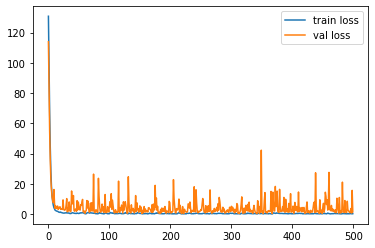

In [21]:
# hyperparameter search
# WARNING: this doesn't collect the results from the best saved models, only the results of the model after 500 epochs. 
# So need to copy printed output and find scores of best models to work out which hyperparameters are actually the best.

import talos
scan_object = talos.Scan(Xtrain_subset,
                         ytrain, 
                         params=to_try,
                         model=featureNN,
                         experiment_name='FeatureNN_HPS',
                         fraction_limit=.25)

In [52]:
# writing to csv
# scan_object.data.to_csv('FeatureNN_HPS_results.csv', sep = '\t')

In [28]:
# evaluate by reading in output, getting best val_accs and adding to results table

saved_accs = []
f = open("output.txt", "r")
for line in f.readlines():
    if 'Epoch 00500:' in line :
        saved_accs.append(line)

len(saved_accs) # should be 48 as we did 48 rounds
nums = [float(saved_accs[i].split(' ')[7].split('\n')[0]) for i in range(len(saved_accs))]
# nums

stats = pd.read_csv('FeatureNN_HPS_results', sep = '\t', index_col= 0)
stats['best_saved_val_acc'] = nums
stats

stats.to_csv('FeatureNN_HPS_results.csv', sep = '\t') # save back to same csv

In [62]:
# looking at results
results = pd.read_csv('FeatureNN_HPS_results.csv', sep = '\t', index_col = 0)
results.sort_values(by = 'best_saved_val_acc')


round_epochs   val_loss  val_categorical_accuracy       loss  \
33           500   2.715056                  0.136331   2.712927   
13           500   2.580514                  0.136331   2.578682   
44           500   2.230888                  0.222698   2.443373   
32           500   2.185716                  0.295503   2.294006   
35           500   2.776359                  0.136331   2.591007   
17           500   3.882282                  0.206281   2.220572   
3            500   5.550797                  0.138473   4.970233   
24           500   1.325257                  0.527480   1.517650   
6            500   3.326526                  0.231263   3.466251   
22           500   2.109602                  0.470378   2.501488   
2            500   1.097943                  0.605996   1.292121   
46           500  14.333808                  0.365453  15.321175   
26           500   1.466760                  0.675946   1.767977   
42           500  12.052294                  0.167024   7.589320   
34           500   7.463618                  0.304069   3.196465   
4            500   4.271393                  0.406852   3.078167   
30           500   2.312067                  0.539615   2.103888   
10           500   1.767785                  0.713776   2.222186   
36           500   7.300935                  0.282655   4.889335   
21           500   2.679565                  0.615275   0.642377   
0            500   1.862610                  0.433262   2.245806   
28           500   0.540547                  0.859386   0.842976   
1            500   7.397644                  0.251963   2.228357   
18           500   2.720363                  0.458958   1.969605   
23           500   2.527832                  0.882227   2.613989   
25           500   1.281598                  0.798001   0.502886   
41           500   8.364463                  0.251249   0.810948   
19           500   0.211191                  0.948608   0.672709   
31           500   2.400204                  0.621699   0.916146   
47           500   1.593293                  0.759458   0.343680   
12           500   2.551110                  0.705924   1.479381   
16           500   0.767158                  0.941470   0.746642   
40           500   0.190866                  0.969308   0.163060   
15           500   0.283851                  0.958601   0.337795   
39           500   0.105865                  0.975018   0.334342   
14           500   0.145096                  0.973590   0.464082   
11           500   0.223045                  0.977873   0.024197   
20           500   0.159888                  0.979300   0.000196   
5            500   0.204647                  0.979300   0.001657   
9            500   0.587509                  0.975732   0.000105   
7            500   0.216721                  0.975732   0.006220   
45           500   0.148817                  0.979300   0.008053   
38           500   0.146694                  0.980728   0.004883   
8            500   0.153802                  0.982869   0.001343   
43           500   0.118187                  0.984297   0.084021   
29           500   0.628813                  0.976445   0.000139   
37           500   0.122567                  0.982156   0.025656   
27           500   0.159713                  0.979300   0.000493   

    categorical_accuracy  input_dropout  \
33              0.123661          False   
13              0.123661           True   
44              0.175696          False   
32              0.258953           True   
35              0.155188           True   
17              0.208142          False   
3               0.256198          False   
24              0.442608           True   
6               0.210897          False   
22              0.320784          False   
2               0.542700          False   
46              0.479645          False   
26              0.566269          False   
42              0.554943          False   
34              0.878176  

round_epochs   val_loss  val_categorical_accuracy       loss  \
0            500   1.862610                  0.433262   2.245806   
1            500   7.397644                  0.251963   2.228357   
2            500   1.097943                  0.605996   1.292121   
3            500   5.550797                  0.138473   4.970233   
4            500   4.271393                  0.406852   3.078167   
5            500   0.204647                  0.979300   0.001657   
6            500   3.326526                  0.231263   3.466251   
7            500   0.216721                  0.975732   0.006220   
8            500   0.153802                  0.982869   0.001343   
9            500   0.587509                  0.975732   0.000105   
10           500   1.767785                  0.713776   2.222186   
11           500   0.223045                  0.977873   0.024197   
12           500   2.551110                  0.705924   1.479381   
13           500   2.580514                  0.136331   2.578682   
14           500   0.145096                  0.973590   0.464082   
15           500   0.283851                  0.958601   0.337795   
16           500   0.767158                  0.941470   0.746642   
17           500   3.882282                  0.206281   2.220572   
18           500   2.720363                  0.458958   1.969605   
19           500   0.211191                  0.948608   0.672709   
20           500   0.159888                  0.979300   0.000196   
21           500   2.679565                  0.615275   0.642377   
22           500   2.109602                  0.470378   2.501488   
23           500   2.527832                  0.882227   2.613989   
24           500   1.325257                  0.527480   1.517650   
25           500   1.281598                  0.798001   0.502886   
26           500   1.466760                  0.675946   1.767977   
27           500   0.159713                  0.979300   0.000493   
28           500   0.540547                  0.859386   0.842976   
29           500   0.628813                  0.976445   0.000139   
30           500   2.312067                  0.539615   2.103888   
31           500   2.400204                  0.621699   0.916146   
32           500   2.185716                  0.295503   2.294006   
33           500   2.715056                  0.136331   2.712927   
34           500   7.463618                  0.304069   3.196465   
35           500   2.776359                  0.136331   2.591007   
36           500   7.300935                  0.282655   4.889335   
37           500   0.122567                  0.982156   0.025656   
38           500   0.146694                  0.980728   0.004883   
39           500   0.105865                  0.975018   0.334342   
40           500   0.190866                  0.969308   0.163060   
41           500   8.364463                  0.251249   0.810948   
42           500  12.052294                  0.167024   7.589320   
43           500   0.118187                  0.984297   0.084021   
44           500   2.230888                  0.222698   2.443373   
45           500   0.148817                  0.979300   0.008053   
46           500  14.333808                  0.365453  15.321175   
47           500   1.593293                  0.759458   0.343680   

    categorical_accuracy  input_dropout  \
0               0.339149           True   
1               0.900826          False   
2               0.542700          False   
3               0.256198          False   
4               0.835629          False   
5               0.999388           True   
6               0.210897          False   
7               0.998776           True   
8               0.999694          False   
9               1.000000          False   
10              0.562902           True   
11              0.991736           True   
12              0.932966          False   
13              0.123661           True   
14              0.853688  

Acc, conf mat:
0.9781491002570694
[[162   0   0   0   1   2   0   0   0   0   0   7   3   0]
 [  0 103   0   1   0   0   0   0   0   0   0   0   0   0]
 [  3   0 194   0   0   0   0   0   1   0   0   0   0   0]
 [  1   0   0  78   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  45   1   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0 131   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0  78   2   0   0   0   0   0   0]
 [  0   1   0   0   0   0   2  66   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0  92   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0 118   0   0   0   0]
 [  1   1   0   0   0   0   0   0   0   0  91   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0 125   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 129   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 110]]
precision, recall, f1 for each class:
[0.93103448 0.98095238 1.         0.98734177 0.97826087 0.97761194
 0.975      0.97058824 0.98924731 

array([12, 11,  4, ...,  0,  6, 12])

                0   1   2   3   4   5   6   7   8   9   10  11  12        13
0.000000  0.000000 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN
0.000000  0.005714 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN
0.000000  0.411429 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN
0.000724  0.411429 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN
0.000724  0.491429 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN
...            ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..       ...
0.000000       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.409091
0.000000       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.545455
0.000000       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.563636
0.000000       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.000000
1.000000       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.000000

[210 rows x 14 columns]
                0   1   2   3   4   5   6   7   8  

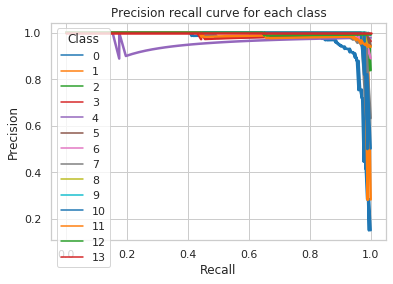

In [10]:
# evaluate
import sys
sys.path.append('/Tank/methylation-patterns-code/methylation-patterns-izzy/')
y_pred = model.predict(Xtest_subset, batch_size=Xtest_subset.shape[0])
import numpy as np

import Evaluate
label = 'FeatureNN_'+cancer_type
if use_small:
    label = label+'small'

from Evaluate import print_evaluation, plot_curve
print_evaluation(None, None, np.argmax(ytest, axis=1), label, predictions=np.argmax(y_pred, axis=1), prob_predictions=y_pred) # fitted and m_values are none because we are providing predictions

import numpy as np
num_classes = len(np.unique(ytest, axis=0))
plot_curve('roc', np.argmax(ytest, axis=1), y_pred, num_classes, label)
plot_curve('precision_recall', np.argmax(ytest, axis=1), y_pred, num_classes, label)



In [ ]:
# saving to file, so don't have to Xtest_subsetle dataset again
def save_to_file():
    values = pd.read_csv('../../data_preprocessing/dataset/pandas/m_values/TCGA-all.csv', sep='\t', usecols=[0])
    # values

    probes = values['probe'][feature_nums]

    # Xtrain_subset
    dm = pd.DataFrame(Xtrain[:, feature_nums].transpose(), index = probes)
    dm.to_csv('TCGA-all-just-xgboost-features_train.csv', sep='\t')

    # Xtest
    dm = pd.DataFrame(Xtest[:, feature_nums].transpose(), index = probes)
    dm.to_csv('TCGA-all-just-xgboost-features_test.csv', sep='\t')

    # diagnoses
    dd = pd.DataFrame(ytrain)
    dd.to_csv('TCGA-all-diagnoses_train.csv', sep='\t')
    dd = pd.DataFrame(ytest)
    dd.to_csv('TCGA-all-diagnoses_test.csv', sep='\t')
